In [77]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

# Importing custom libraries
import sys
sys.path.append('/utilities/')
from utilities.datawindow import DataWindow
from utilities.airquality import AirQuality

REFRESH_DATA = False
DATA_QUANTITY = 200

### Helper Functions

In [78]:
def pivot_dataframe(input_df, identifier_col, value_col):

    unique_vals = input_df[identifier_col].drop_duplicates().to_list()
    independent_series = {}
    for val in unique_vals:
        independent_series[val] = input_df[input_df[identifier_col] == val][value_col].to_list()
    output_df = pd.DataFrame(independent_series)
    output_df['Date'] = input_df['Date'].drop_duplicates().to_list()
    #independent_series['Date'] = input_df['Date'].drop_duplicates().to_list()

    return output_df
    





### Reading Data

In [79]:
# Defining city id's
ids = ['1064', '1067']


# Creating 
combined_df = []
if REFRESH_DATA:
    air_measurements = []
    # Iterating through sensor locations and creating object to store data for each
    for location in ids:
        quality = AirQuality(location)
        quality.pull_data(DATA_QUANTITY )
        air_measurements.append(quality.raw_data)

    combined_df = pd.concat(air_measurements)
    combined_df.to_csv('./Data/air_polution.csv')
else:
    combined_df = pd.read_csv('./Data/air_polution.csv')
    combined_df = combined_df.drop(columns = ['Unnamed: 0'])

combined_df['location'] = combined_df['location'].astype(str)
combined_df = combined_df.drop(columns = ['Date'])
combined_df = combined_df.rename(columns = {'Data_Converted': 'Date'})
combined_df = combined_df[combined_df['location'].isin(ids)].reset_index(drop=True)
combined_df.head(10)

,Value,location,parameter,longitude,latitude,Date
0,2.8,1064,pm25,-122.602877,45.496641,2024-08-22 12:00:00+00:00
1,2.7,1064,pm25,-122.602877,45.496641,2024-08-22 11:00:00+00:00
2,2.6,1064,pm25,-122.602877,45.496641,2024-08-22 10:00:00+00:00
3,2.7,1064,pm25,-122.602877,45.496641,2024-08-22 09:00:00+00:00
4,2.6,1064,pm25,-122.602877,45.496641,2024-08-22 08:00:00+00:00
5,2.5,1064,pm25,-122.602877,45.496641,2024-08-22 07:00:00+00:00
6,2.4,1064,pm25,-122.602877,45.496641,2024-08-22 06:00:00+00:00
7,2.7,1064,pm25,-122.602877,45.496641,2024-08-22 05:00:00+00:00
8,2.7,1064,pm25,-122.602877,45.496641,2024-08-22 04:00:00+00:00
9,2.9,1064,pm25,-122.602877,45.496641,2024-08-22 03:00:00+00:00


In [80]:
identifier_col = 'location'
value_col = 'Value'
formatted_df = pivot_dataframe(combined_df, identifier_col, value_col)

### Creating Test/Train Sets

In [81]:
total_observations = len(formatted_df)
train_ratio, val_ratio = 0.6, 0.8

train_df = formatted_df[:int(total_observations * train_ratio)]
val_df = formatted_df[int(total_observations * train_ratio):int(total_observations * val_ratio)]
test_df = formatted_df[int(total_observations * val_ratio):]


### Multi Output Baseline Model

In [82]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, 
                                   train_df = train_df, val_df = val_df, test_df = test_df,
                                   label_columns=ids) 
mo_wide_window = DataWindow(input_width=5, label_width=5, shift=1, 
                            train_df = train_df, val_df = val_df, test_df = test_df,
                            label_columns=ids)
column_indices = {name: i for i, name in enumerate(train_df.columns)}
print(column_indices)

{'1064': 0, '1067': 1, 'Date': 2}


In [83]:
mo_baseline_last = Baseline(label_index=[0, 1])
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

NameError: name 'Baseline' is not defined

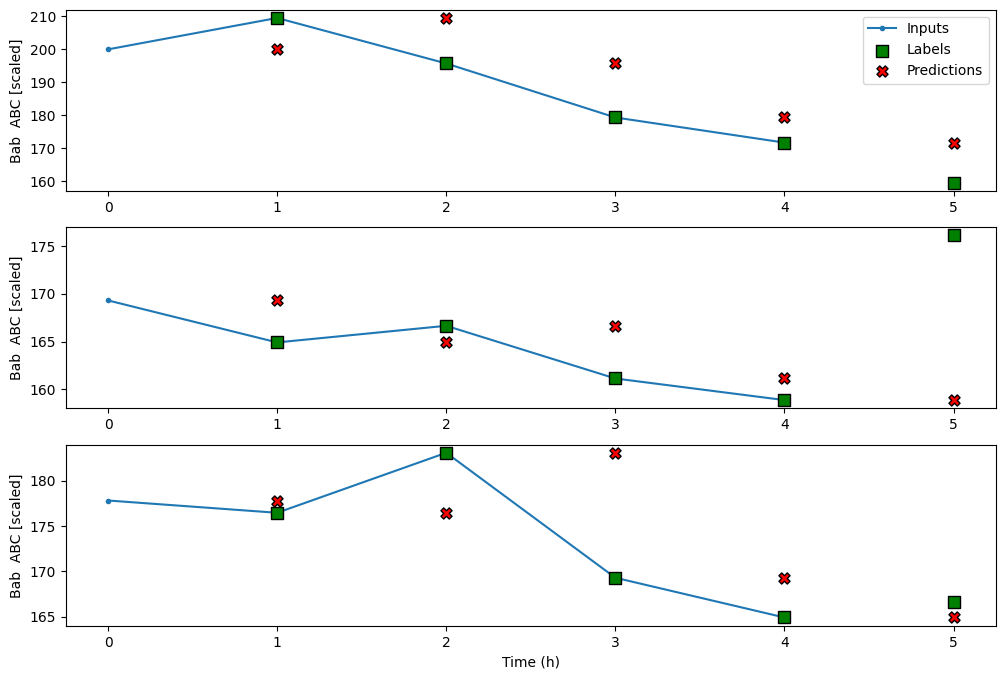

In [145]:
mo_wide_window.plot(mo_baseline_last, plot_col='Bab  ABC')